# Causal ML, Uplift Modeling Part 1

## Import Libraries & Data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklift.metrics import uplift_at_k,qini_auc_score
from sklift.datasets import fetch_hillstrom

In [62]:
# 1. Load Hillstrom dataset
def load_hillstrom():
    dataset = fetch_hillstrom()
    df = dataset.data
    df['segment'] = dataset.treatment
    df['visit'] = dataset.target
    print(df.info())
    print(df.isna().sum())
    return df

df = load_hillstrom()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  object 
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  object 
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  object 
 8   segment          64000 non-null  object 
 9   visit            64000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 4.9+ MB
None
recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
segment            0
visit              0
dtype: int64


## Explore Data

In [63]:
# The treatment
df['segment'].value_counts()

segment
Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: count, dtype: int64

In [64]:
# There appears to be 2 segments, let's just use the mens email to start
df = df.loc[df['segment'].isin(['Mens E-Mail','No E-Mail'])]
df['treatment'] = df['segment'].map({'Mens E-Mail':1,'No E-Mail':0})
df['treatment'].value_counts(normalize=True)

treatment
1    0.500012
0    0.499988
Name: proportion, dtype: float64

In [65]:
# This dataset has visit, conversion, and revenue as the target variables, we are going to use visit as the target variable
df['target'] = df['visit'].copy()
df['target'].value_counts()

target
0    36457
1     6156
Name: count, dtype: int64

In [66]:
df['mens'].value_counts()

mens
1    23526
0    19087
Name: count, dtype: int64

In [67]:
df['womens'].value_counts()

womens
1    23417
0    19196
Name: count, dtype: int64

In [68]:
df['history_segment'].value_counts()

history_segment
1) $0 - $100        15336
2) $100 - $200       9527
3) $200 - $350       8134
4) $350 - $500       4221
5) $500 - $750       3249
6) $750 - $1,000     1266
7) $1,000 +           880
Name: count, dtype: int64

In [69]:
df['history'].describe()

count    42613.000000
mean       241.859315
std        256.574723
min         29.990000
25%         64.500000
50%        157.000000
75%        325.210000
max       3345.930000
Name: history, dtype: float64

In [70]:
df['recency'].value_counts()

recency
1     5934
2     5074
10    5022
9     4330
3     3899
4     3406
6     3048
5     2985
7     2720
8     2337
11    2316
12    1542
Name: count, dtype: int64

In [71]:
df['newbie'].value_counts()

newbie
1    21381
0    21232
Name: count, dtype: int64

In [72]:
df['channel'].value_counts()

channel
Web             18863
Phone           18567
Multichannel     5183
Name: count, dtype: int64

In [73]:
df['zip_code'].value_counts()

zip_code
Surburban    19126
Urban        17105
Rural         6382
Name: count, dtype: int64

In [75]:
df = pd.get_dummies(df, columns=['zip_code'], drop_first=True, dtype=int)  # Encode categorical variable
df = pd.get_dummies(df, columns=['channel'], drop_first=True, dtype=int)  # Encode categorical variable
df = df.drop(columns=['history_segment','segment','visit'])

In [76]:
df.head()

,recency,history,mens,womens,newbie,treatment,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
1,6,329.08,1,1,1,0,0,0,0,0,1
3,9,675.83,1,0,1,1,0,0,0,0,1
8,9,675.07,1,1,1,1,0,0,0,1,0
13,2,101.64,0,1,0,1,1,0,1,0,1
14,4,241.42,0,1,1,0,0,0,0,0,0


In [78]:
# It appears everything is just about equal in terms of the treatment group and the control group for feature means, except the target which is ok
df.groupby('treatment').mean()

,recency,history,mens,womens,newbie,target,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
treatment,,,,,,,,,,
0,5.749695,240.882653,0.553224,0.547639,0.501971,0.106167,0.451751,0.400920,0.437764,0.439923
1,5.773642,242.835931,0.550946,0.551415,0.501525,0.182757,0.445910,0.401887,0.433660,0.445394


## Split Train Test

In [79]:
# 2. Split data into train/test
def split_data(df):
    X = df.drop(columns=['treatment', 'target'])
    y = df['target']
    treatment = df['treatment']
    return train_test_split(X, y, treatment, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test, t_train, t_test = split_data(df)

## Run Two Model Approach, the traditional uplift model approach

In [80]:
# 3. Two-Model Approach
def two_model_approach(X_train, y_train, t_train, X_test):
    model_treatment = RandomForestClassifier(random_state=42)
    model_control = RandomForestClassifier(random_state=42)

    # Train separate models for treatment and control
    model_treatment.fit(X_train[t_train == 1], y_train[t_train == 1])
    model_control.fit(X_train[t_train == 0], y_train[t_train == 0])

    # Predict probabilities
    uplift_treatment = model_treatment.predict_proba(X_test)[:, 1]
    uplift_control = model_control.predict_proba(X_test)[:, 1]

    uplift = uplift_treatment - uplift_control
    return uplift

uplift_two_model = two_model_approach(X_train, y_train, t_train, X_test)

In [5]:
# 4. S-Learner
def single_model(X_train, y_train, t_train, X_test):
    X_train_s = X_train.copy()
    X_train_s['treatment'] = t_train

    X_test_s = X_test.copy()
    X_test_s['treatment'] = 1  # Predict as if treated
    X_test_c = X_test.copy()
    X_test_c['treatment'] = 0  # Predict as if control

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_s, y_train)

    uplift_treatment = model.predict_proba(X_test_s)[:, 1]
    uplift_control = model.predict_proba(X_test_c)[:, 1]

    uplift = uplift_treatment - uplift_control
    return uplift

uplift_s_learner = single_model(X_train, y_train, t_train, X_test)

### Two-Model Approach Evaluation ###
Two-Model Qini Score: 0.0170


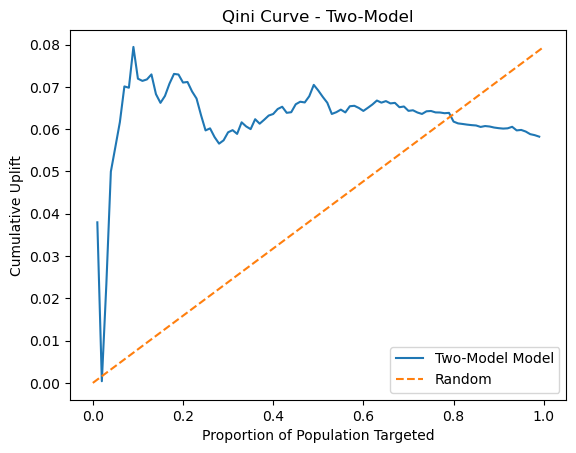

### S-Learner Evaluation ###
S-Learner Qini Score: 0.0147


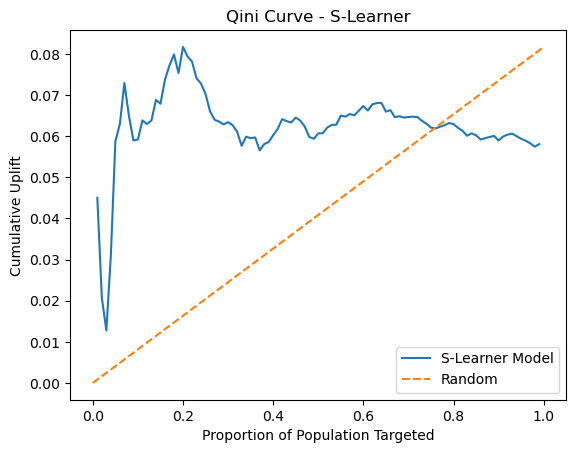

In [6]:
# 5. Enhanced Qini Evaluation
def evaluate_qini(uplift, y_test, t_test, model_name):
    qini = qini_auc_score(y_test, uplift, t_test)

    # Use a loop to calculate uplift at different percentages
    k_values = [i / 100 for i in range(1, 100)]  # Generate k as float values from 0.01 to 1
    uplift_cumulative = []

    for k in k_values:
        uplift_k = uplift_at_k(y_test, uplift, t_test, strategy='overall', k=k)
        uplift_cumulative.append(uplift_k)

    print(f"{model_name} Qini Score: {qini:.4f}")

    # Plot the Qini Curve
    plt.plot(k_values, uplift_cumulative, label=f'{model_name} Model')
    plt.plot([0, 1], [0, max(uplift_cumulative)], '--', label='Random')
    plt.xlabel('Proportion of Population Targeted')
    plt.ylabel('Cumulative Uplift')
    plt.title(f'Qini Curve - {model_name}')
    plt.legend()
    plt.show()

# Compare Two-Model and S-Learner
print("### Two-Model Approach Evaluation ###")
evaluate_qini(uplift_two_model, y_test, t_test, "Two-Model")

print("### S-Learner Evaluation ###")
evaluate_qini(uplift_s_learner, y_test, t_test, "S-Learner")


In [23]:
# 6. Tabular Comparison of Qini Scores
qini_two_model = qini_auc_score(y_test, uplift_two_model, t_test)
qini_s_learner = qini_auc_score(y_test, uplift_s_learner, t_test)

comparison_df = pd.DataFrame({
    'Model': ['Two-Model', 'S-Learner'],
    'Qini Score': [qini_two_model, qini_s_learner]
})
print("\n### Qini Score Comparison ###")
print(comparison_df)


### Qini Score Comparison ###
       Model  Qini Score
0  Two-Model    0.016977
1  S-Learner    0.014739
